- https://www.kaggle.com/code/mohitsital/top-10-bike-sharing-rf-gbm

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# Global Variables

In [2]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_samples_{0:.5f}.csv'

args.SEED = 42
args.target = 'count'
args.numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
args.category_cols = ['season', 'holiday', 'weather']

args.result_list = []

In [3]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# Load data

In [4]:
dfs = {}
file_paths = [args.train_path, args.test_path]
file_names = ['train', 'test']
for name, path in list(zip(file_names, file_paths)):
    df = pd.read_csv(path)
    df['_data'] = name
    dfs[name] = df

In [5]:
# combine train and test data into one df
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)

<ipython-input-5-c456a955bb9f>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = dfs['train'].append(dfs['test'])


In [6]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)

In [7]:
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(df['datetime'])
df.set_index(dt, inplace=True)

df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear

<ipython-input-7-a5f754c4817a>:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['woy'] = dt.weekofyear


In [10]:
fnc = lambda x: (0, 1)[
    (x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 13))
    or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)
]
df['peak'] = df[['hour', 'workingday']].apply(fnc , axis = 1)


<ipython-input-10-da524624cbc4>:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  fnc = lambda x: (0, 1)[


# sandy

In [11]:
#sandy
cond1 = lambda x: (x['holiday'], 1)[
    x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])
]
df['holiday'] = df[['month', 'day', 'holiday', 'year']].apply(cond1, axis = 1)


<ipython-input-11-a7127b344fdc>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cond1 = lambda x: (x['holiday'], 1)[


# christmas day and others

In [12]:
#christmas day and others
cond2 = lambda x: (x['holiday'], 1)[
    x['month'] == 12 and (x['day'] in [24, 26, 31])
]
df['holiday'] = df[['month', 'day', 'holiday']].apply(cond2, axis = 1)

cond3 = lambda x: (x['workingday'], 0)[
    x['month'] == 12 and x['day'] in [24, 31]
]
df['workingday'] = df[['month', 'day', 'workingday']].apply(cond3, axis = 1)


<ipython-input-12-4334ddbc1f23>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cond2 = lambda x: (x['holiday'], 1)[
<ipython-input-12-4334ddbc1f23>:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cond3 = lambda x: (x['workingday'], 0)[


In [13]:
cond1 = lambda x: (0, 1)[
    x['temp'] > 27 and x['windspeed'] < 30
]
df['ideal'] = df[['temp', 'windspeed']].apply(cond1, axis = 1)

cond2 = lambda x: (0, 1)[
    x['workingday'] == 1 and x['humidity'] >= 60
]
df['sticky'] = df[['humidity', 'workingday']].apply(cond2, axis = 1)

<ipython-input-13-48364694fbbe>:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cond1 = lambda x: (0, 1)[
<ipython-input-13-48364694fbbe>:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  cond2 = lambda x: (0, 1)[


In [14]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    data = df[df['_data'] == 'train'].copy()
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test


def prep_data(data, input_cols):
    X = data[input_cols]
    y_r = data['registered_log']
    y_c = data['casual_log']

    return X, y_r, y_c


def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = df[df['_data'] == 'test'].copy()

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    df_train = df[df['_data'] == 'train'].copy()
    X_train = df_train[x_cols]
    y_train_cas = df_train['casual_log']
    y_train_reg = df_train['registered_log']

    # prepare test set
    X_test = df_test[x_cols]

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

# random forest model

In [15]:
# random forest model
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak',
]
rf_p, rf_t, rf_score = predict_on_validation_set(rf_model, rf_cols)
print(rf_score)

0.4413157593431414


# GBM model

In [17]:
# GBM model
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'squared_error'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal'
    ]


(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print(gbm_score)

# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print(get_rmsle(y_p, rf_t))

0.32114136782119934
0.32425556187988525


# predctions on test dataset

In [18]:
# predctions on test dataset
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)

<Axes: ylabel='Count'>

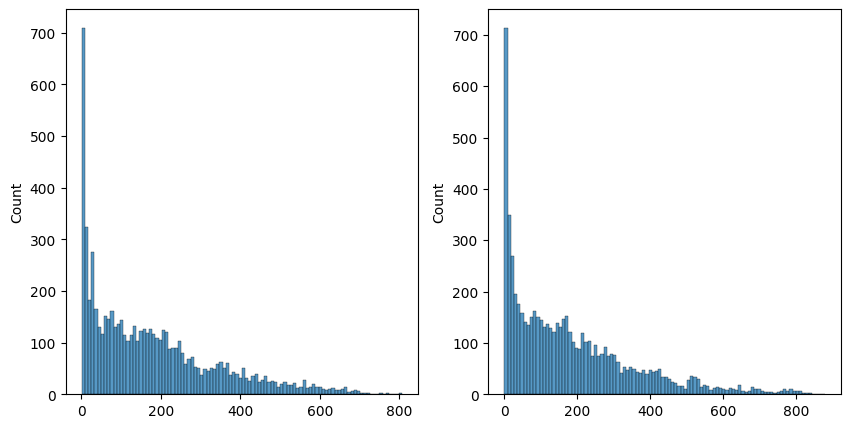

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,5)

sns.histplot(rf_pred, bins=100, ax=ax1)
sns.histplot(gbm_pred, bins=100, ax=ax2)

# taking weighted average of output from two models

In [20]:
# taking weighted average of output from two models
y_pred = np.round(.20*rf_pred + .80*gbm_pred)

<Axes: ylabel='Count'>

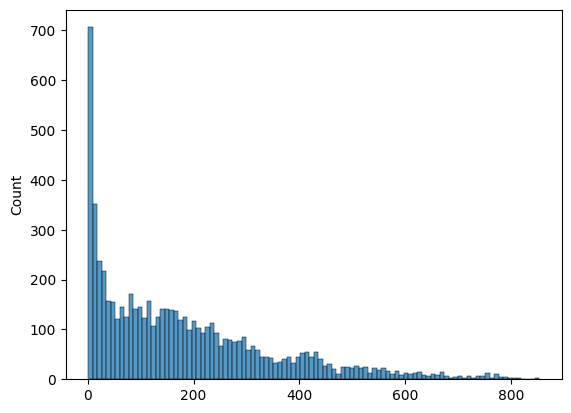

In [21]:
sns.histplot(y_pred, bins=100)